In [1]:
# Importing necessary libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner


In [2]:

# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)
# Listing available GPUs
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# Removing non-JPEG images from the "Cat" and "Dog" folders
import os
num_skipped = 0
for folder_name in ("Cat","Dog"):
    folder_path = os.path.join('PetImages',folder_name)
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path,file_name)
        try:
            file_obj = open(file_path,"rb")
            is_jfif = tf.compat.as_bytes("JFIF") in file_obj.peek(10)
        finally:
            file_obj.close()
        
        if not is_jfif:
            num_skipped += 1

            os.remove(file_path)

print("Deleted %d images" % num_skipped)

Deleted 1578 images


In [28]:
# Defining image size, batch size, and loading the dataset

image_size = (128,128)
batch_size = 64

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    'PetImages',
    validation_split=0.2,
    subset="both",
    seed = 42,
    image_size=image_size,
    batch_size=batch_size
)

Found 23422 files belonging to 2 classes.
Using 18738 files for training.
Using 4684 files for validation.


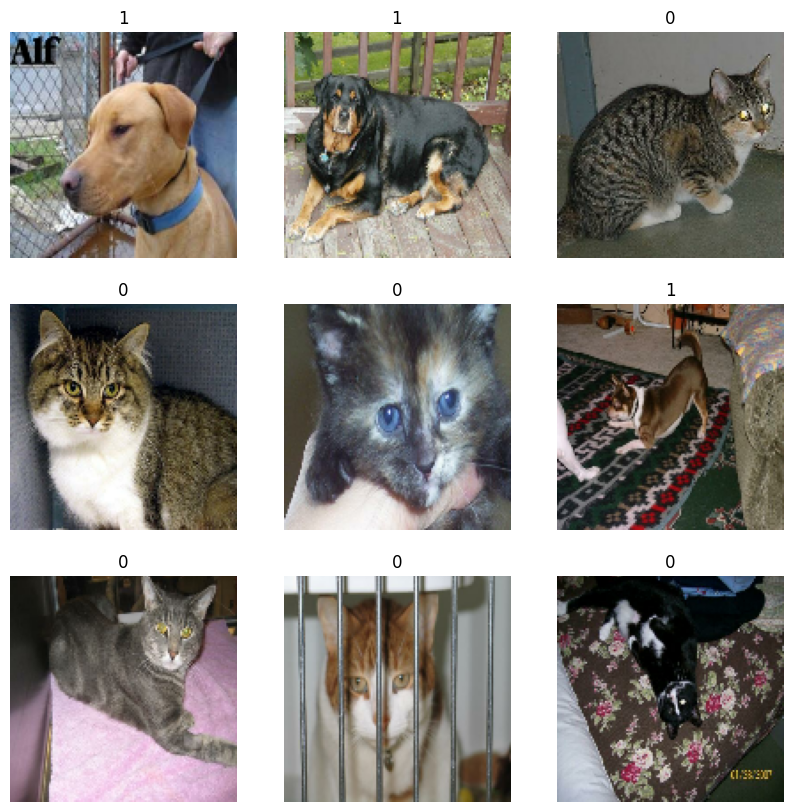

In [7]:
import matplotlib.pyplot as plt
# Displaying sample images with their labels

plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [8]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1)
    ]
)
# Defining data augmentation techniques

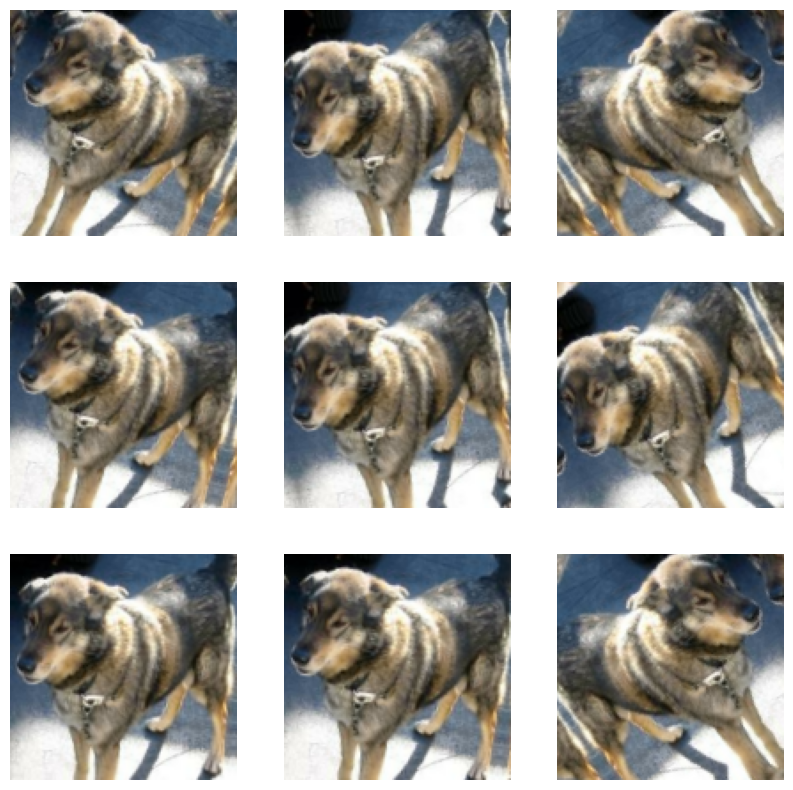

In [9]:
plt.figure(figsize=(10,10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3,3,i+1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")
        
# Displaying augmented images


In [29]:
# Preprocessing input images
input_shape = (128,128,3)
inputs = keras.Input(shape=input_shape)
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)

In [30]:
#Apply 'data_augmentation' to the training image
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img),label),
    num_parallel_calls = tf.data.AUTOTUNE
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [31]:
# Creating the model architecture

def make_model(input_shape,num_classes):
    inputs = keras.Input(shape=input_shape)

    #Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(64,3,strides = 2, padding = "same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    # Intermediate blocks
    previous_block_activation = x

    for size in [64,128,256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size,3,padding = "same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size,3,padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size,3,padding="same")(x)
        x = layers.BatchNormalization()(x)

        

        x = layers.MaxPooling2D(3,strides=2,padding="same")(x)

        residual = layers.Conv2D(size,1,strides=2,padding="same")(
            previous_block_activation
        )

        x = layers.add([x,residual])
        previous_block_activation = x

    # Head block
    x = layers.SeparableConv2D(256,3,padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units,activation=activation)(x)
    return keras.Model(inputs,outputs)

# Visualizing the model architecture
model = make_model(input_shape=image_size + (3,),num_classes=2)
keras.utils.plot_model(model,show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [34]:
# Modeli derlemeden önce kayıp ve doğruluk geçmişini toplamak için listeler oluşturalım
train_loss = []
train_accuracy = []
val_loss = []
val_accuracy = []

# Eğitim sürecinde kayıp ve doğruluk metriklerini takip edelim
class CustomCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        train_loss.append(logs["loss"])
        train_accuracy.append(logs["accuracy"])
        val_loss.append(logs["val_loss"])
        val_accuracy.append(logs["val_accuracy"])

In [35]:
# Compiling and training the model
epochs = 30

callbacks = [
    keras.callbacks.ModelCheckpoint("save_path_{epoch}.keras"),
    CustomCallback()  # CustomCallback'u callback listesine ekleyelim

]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss = "binary_crossentropy",
    metrics = ["accuracy"],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)


Epoch 1/30


293/293 [==============================] - 41s 134ms/step - loss: 0.5171 - accuracy: 0.7463 - val_loss: 1.1803 - val_accuracy: 0.4932
Epoch 2/30
293/293 [==============================] - 39s 132ms/step - loss: 0.3823 - accuracy: 0.8337 - val_loss: 0.9269 - val_accuracy: 0.5895
Epoch 3/30
293/293 [==============================] - 39s 134ms/step - loss: 0.2949 - accuracy: 0.8729 - val_loss: 0.3812 - val_accuracy: 0.8339
Epoch 4/30
293/293 [==============================] - 39s 134ms/step - loss: 0.2356 - accuracy: 0.9033 - val_loss: 0.5405 - val_accuracy: 0.7018
Epoch 5/30
293/293 [==============================] - 39s 133ms/step - loss: 0.1916 - accuracy: 0.9222 - val_loss: 0.8075 - val_accuracy: 0.6456
Epoch 6/30
293/293 [==============================] - 39s 133ms/step - loss: 0.1594 - accuracy: 0.9354 - val_loss: 0.3077 - val_accuracy: 0.8728
Epoch 7/30
293/293 [==============================] - 39s 133ms/step - loss: 0.1390 - accuracy: 0.9459 - val_loss: 0.5453 - val_accuracy: 0.8

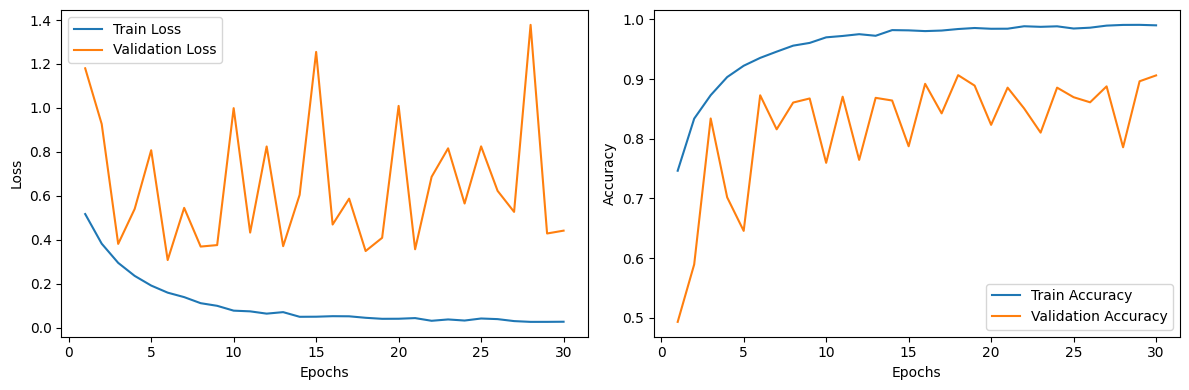

In [36]:
# Plotting loss and accuracy curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_loss, label="Train Loss")
plt.plot(range(1, epochs + 1), val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracy, label="Train Accuracy")
plt.plot(range(1, epochs + 1), val_accuracy, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

In [118]:
# Making predictions on a single image
img = keras.utils.load_img(
    "PetImages/Cat/6000.jpg", target_size=image_size
)
img_array = keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
predictions = model.predict(img_array)
score = float(predictions[0])
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")

1/1 [==============================] - 0s 24ms/step
This image is 99.70% cat and 0.30% dog.


C:\Users\erayd\AppData\Local\Temp\ipykernel_9672\792468247.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = float(predictions[0])


50/50 [==============================] - 1s 15ms/step


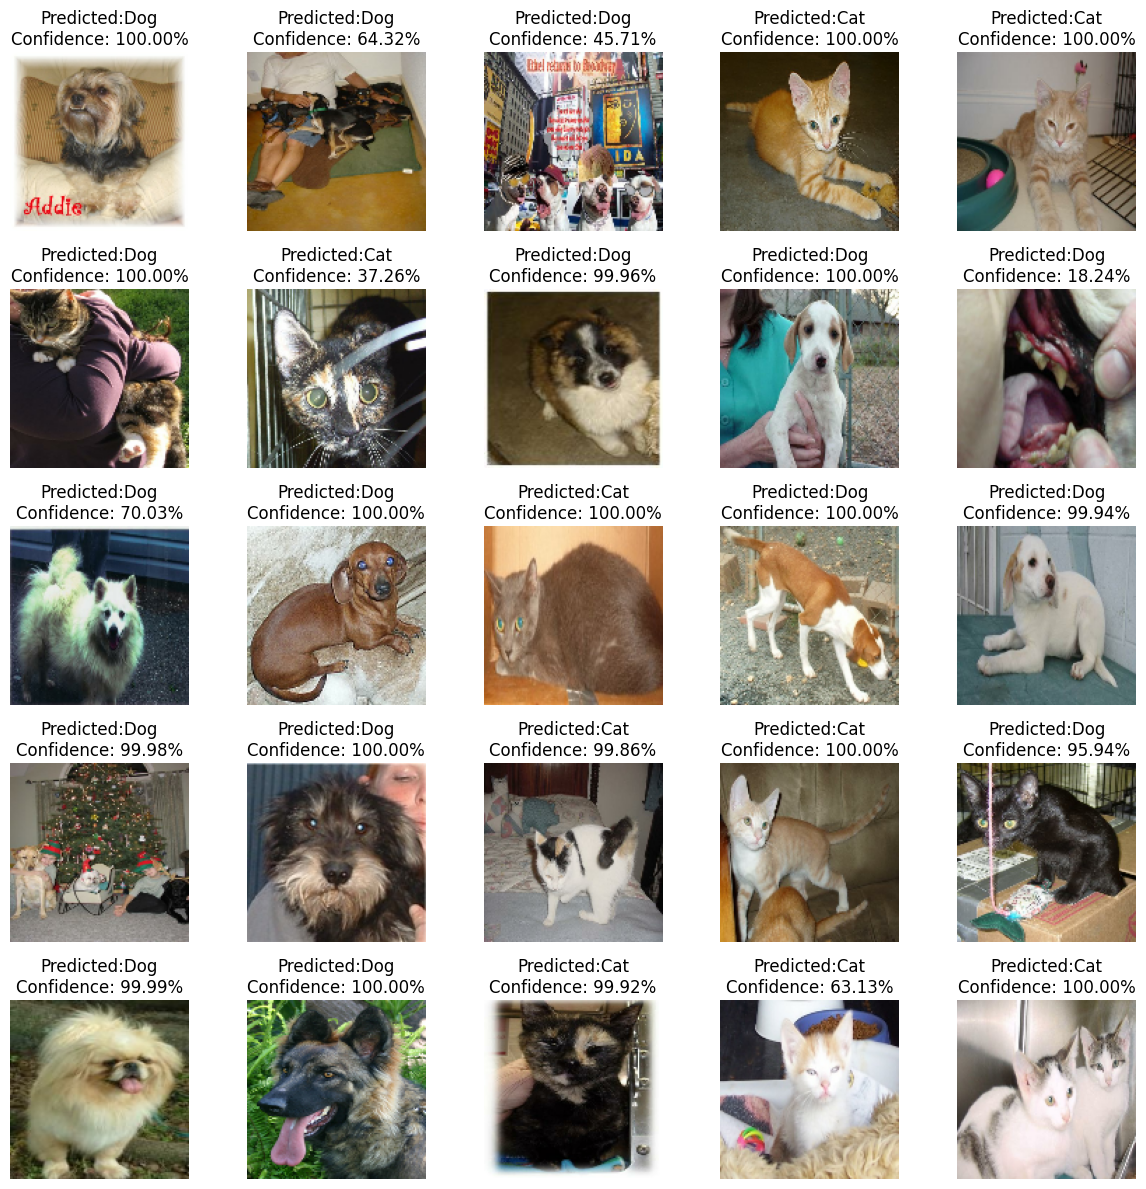

In [138]:
import numpy as np

# Select 25 images from the validation dataset
images = []
labels = []
for image, label in val_ds.take(25):
    images.append(image)
    labels.append(label)

images = tf.concat(images, axis=0)

# Make predictions on the selected images
predictions = model.predict(images)
predicted_labels = np.round(predictions).flatten()
confidences = np.abs(predictions.flatten() - 0.5) * 2

# Visualize the images and predictions
plt.figure(figsize=(12, 12))
for i in range(25):
    ax = plt.subplot(5, 5, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    if predicted_labels[i] == 1:
        plt.title(f"Predicted:Dog\nConfidence: {confidences[i]:.2%}")
    else:
        plt.title(f"Predicted:Cat\nConfidence: {confidences[i]:.2%}")
    plt.axis("off")
    
plt.tight_layout()
plt.show()


50/50 [==============================] - 1s 15ms/step


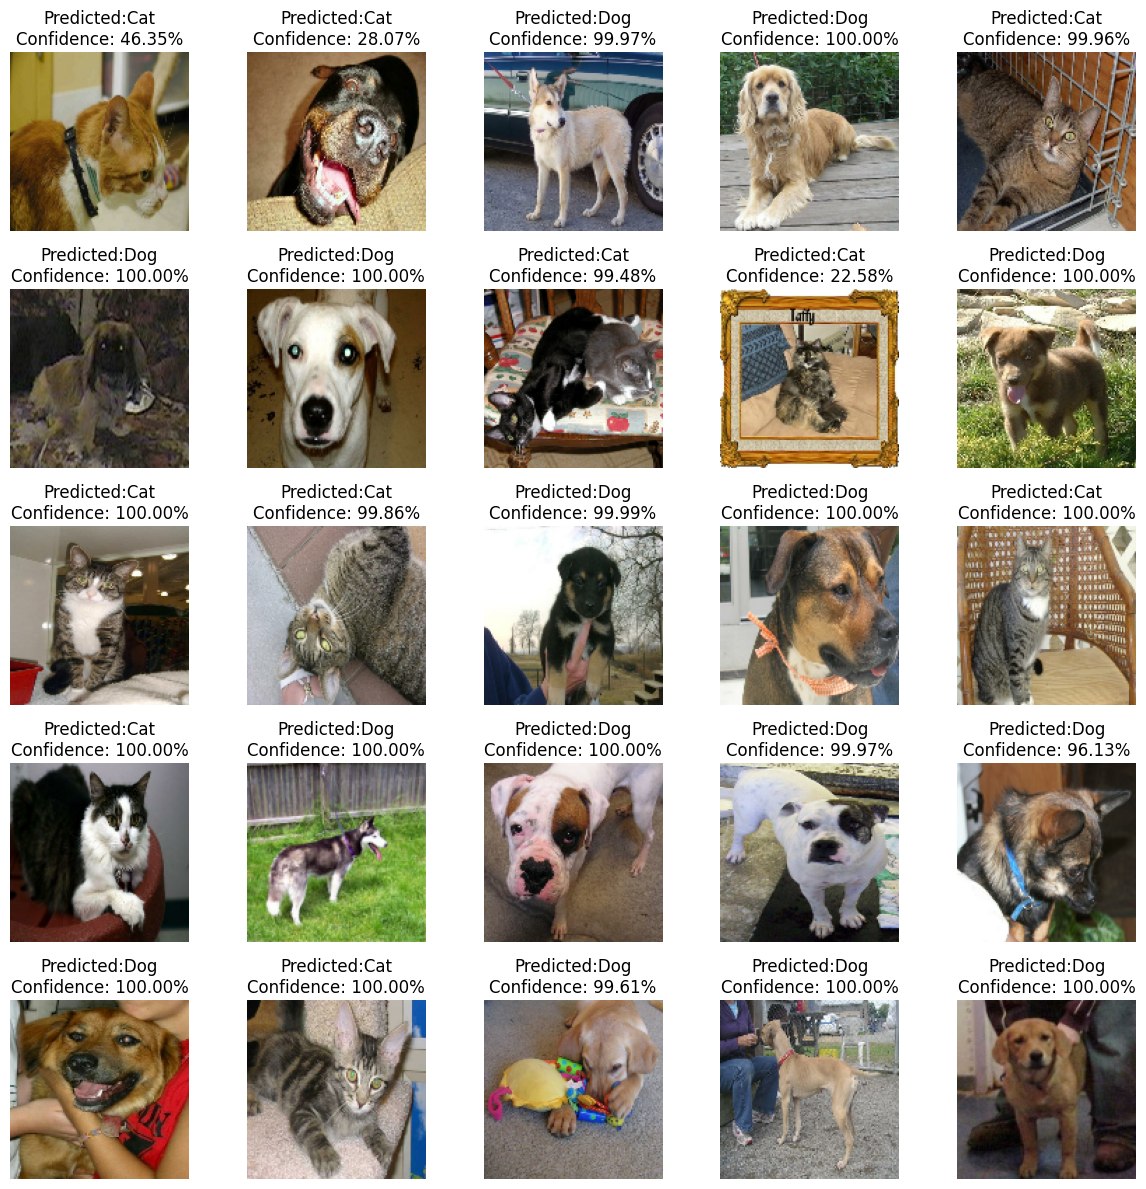

In [139]:
import random
import numpy as np

# Select 25 random images from the validation dataset
random_images = random.sample(list(val_ds), 25)

images = []
labels = []
for image, label in random_images:
    images.append(image)
    labels.append(label)

images = tf.concat(images, axis=0)

# Make predictions on the selected images
predictions = model.predict(images)
predicted_labels = np.round(predictions).flatten()
confidences = np.abs(predictions.flatten() - 0.5) * 2

# Visualize the images and predictions
plt.figure(figsize=(12, 12))
for i in range(25):
    ax = plt.subplot(5, 5, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    if predicted_labels[i] == 1:
        plt.title(f"Predicted:Dog\nConfidence: {confidences[i]:.2%}")
    else:
        plt.title(f"Predicted:Cat\nConfidence: {confidences[i]:.2%}")
    plt.axis("off")
    
plt.tight_layout()
plt.show()
